In [22]:
import sys, os
sys.path.append("../main")
import ZI
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('dark_background')

# Esempio

Per prima cosa carico il dataframe ottenuto attraverso il notebook clean data.

In [23]:
df = ZI.load_LOB_data("../data/energia/order/new_best.csv")
# Considero solamente gli lo stato del book nel giorno 01/10/2021
df = df[df["Datetime"].dt.day == 1]

Dopo aver caricato i dati devo calcolare il valore dei parametri $\lambda$, $\mu$ e $\delta$, ovvero i rate di arrivo dei LO, MO e cancellazioni.

Per calcolarli seguo la procedura presentata nel libro di Buchad.

Chiamati:
- $X_{LO}$ l'insieme dei LO piazzati al best price o all'interno dello spread.
- $X_{MO}$ l'insieme dei MO.
- $X_C$ l'insieme delle cancellazioni avvenute al best bid o best ask.

e definiti $N_{LO}$, $N_{MO}$ e $N_C$ come il numero totale di ordini negli insiemi precedenti, i parametri del processo ZI possono essere stimati nella maniera seguente:

- Il volume degli ordini è:
    $$v_0 = \frac{1}{N_{LO}}\sum_{x \in X_{LO}}v_x$$
- Il rate di arrivo dei MO è:
    $$2\hat{\mu} = \frac{1}{N_{LO} + N_{MO} + N_C} \sum_{x \in X_{MO}} \frac{v_x}{v_0}$$
- Il rate totale di arrivo dei LO è:
    $$ 2\hat{\lambda}_{all} = \frac{N_{LO}}{N_{LO} + N_{MO} + N_C}$$
    (per ottenere il rate di arrivo per ogni livello di prezzo va poi diviso per lo spread medio)
- Il rate delle cancellazioni è:
    $$  2\hat{\delta} = \frac{1}{N_{LO} + N_{MO} + N_C} \sum_{x \in X_C} \frac{v_x}{ \bar{V}} $$
    con:
    $$ \bar{V} \equiv \frac{\bar{V_a} + \bar{V_b}}{2} $$
    (Volume medio alle migliori quote)

Per trovare i parametri del modello utilizzo la funzione find_parameters della libreria ZI:

### Input
1. df: pd.DataFrame
    - DataFrame dei dati puliti con il notebook clean data
    
### Output
1. lam: float
    - Rate di arrivo LO 
2. mu: float
    - Rate arrivo MO
2. delta: float
    - Rate arrivo cancellazioni

In [11]:
rate_l, rate_m, rate_c = ZI.find_parameters(df)

print(f"lambda = {rate_l:.4f}, mu = {rate_m:.3f}, delta = {rate_c:.3f}")

lambda = 0.0056, mu = 0.074, delta = 0.137


# Simulazioni con il modello ZI

La funzione principale della libreria ZI è sim_LOB.

### Input

- l_rate (float):
    - Rate di arrivo dei limit orders per unità di tempo e per prezzo.
    
- m_rate (float):
    - Rate di arrivo dei market orders.
    
- c_rate (float):
    - Rate probabilità di cancellazione di un ordine.
    
- m0 (int): default = 0
    - Mid price iniziale da cui far partire le simulazioni.
    
- k (int) default = 100
    - Grandezza LOB. Per motivi di velocità computazionale bisogna tagliare il LOB ad una certa distanza dal mid price. In generale bisogna scegliere un valore di k almeno 10 volte più grande dello spread medio.
    
- iterations (int) default = 10_000:
    - Numero di iterazioni della simulazione.
    
- burn (int) default = None:
    - Numero di iterazioni iniziali da scartare. Se nessun valore viene fornito si scarta un numero di iterazioni pari a int(iterations / 3)

### Output
La funzione ritorna 2 DataFrame:

- df_m
- df_o

   

In [13]:
#faccio partire una simulazione con 50_000 iterazioni utilizzando
# i parametri ricavati da TSLA
message, order = ZI.sim_LOB(rate_l, rate_m, rate_c, m0 = 10_000,  k = 500, 
                                iterations = 50_000, burn = 10_000)


Il primo dataframe (o anche message dataframe) contiene le seguenti informazioni:

- Spread (int)
    - Il bid-ask spread subito dopo l'arrivo di un ordine espresso in tick.
- MidPrice (int)
    - Il mid price subito dopo l'arrivo di un ordine espresso in tick.
- Price (int)
    - Il prezzo di un ordine espresso in tick.
- Type {"Limit", "Market", "Cancel"}
    - Il tipo di un ordine.
- Sign {-1, 1}
    - Il segno di un ordine (-1 = sell, +1 = buy).

In [14]:
message.head()

,Spread,MidPrice,Price,Type,Sign
0,68.0,10280.0,10276.0,Limit,1.0
1,68.0,10280.0,10474.0,Cancel,-1.0
2,68.0,10280.0,10185.0,Cancel,1.0
3,68.0,10280.0,10033.0,Limit,1.0
4,68.0,10280.0,10064.0,Limit,1.0


Il secondo dataframe (order dataframe) contiene il prezzo e il volume delle 10 migliori quote dell'ask e del bid.

In [15]:
order.head()

,AskPrice_0,AskVolume_0,BidPrice_0,BidVolume_0,AskPrice_1,AskVolume_1,BidPrice_1,BidVolume_1,AskPrice_2,AskVolume_2,...,BidPrice_7,BidVolume_7,AskPrice_8,AskVolume_8,BidPrice_8,BidVolume_8,AskPrice_9,AskVolume_9,BidPrice_9,BidVolume_9
0,10314.0,1.0,10246.0,1.0,10319.0,1.0,10185.0,1.0,10324.0,1.0,...,10032.0,1.0,10474.0,1.0,10030.0,0.0,10488.0,1.0,10030.0,0.0
1,10314.0,1.0,10246.0,1.0,10319.0,1.0,10185.0,1.0,10324.0,1.0,...,10032.0,1.0,10488.0,1.0,10030.0,0.0,10489.0,1.0,10030.0,0.0
2,10314.0,1.0,10246.0,1.0,10319.0,1.0,10160.0,1.0,10324.0,1.0,...,10030.0,0.0,10488.0,1.0,10030.0,0.0,10489.0,1.0,10030.0,0.0
3,10314.0,1.0,10246.0,1.0,10319.0,1.0,10160.0,1.0,10324.0,1.0,...,10032.0,1.0,10488.0,1.0,10030.0,0.0,10489.0,1.0,10030.0,0.0
4,10314.0,1.0,10246.0,1.0,10319.0,1.0,10160.0,1.0,10324.0,1.0,...,10033.0,1.0,10488.0,1.0,10032.0,1.0,10489.0,1.0,10030.0,0.0


Possiamo usare i due dataframe per graficare l'andamento del mid price

<AxesSubplot:>

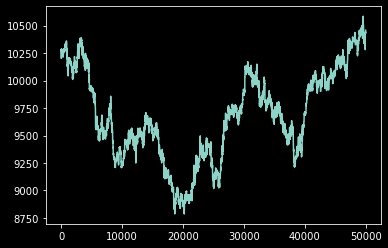

In [16]:
message["MidPrice"].plot()

Per fare l'istogramma del bid-ask spread

<AxesSubplot:>

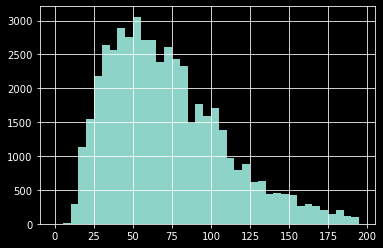

In [21]:
message["Spread"].hist(bins=np.arange(0,200,5))

Per fare un grafico a barre del tipo degli ordini

<AxesSubplot:>

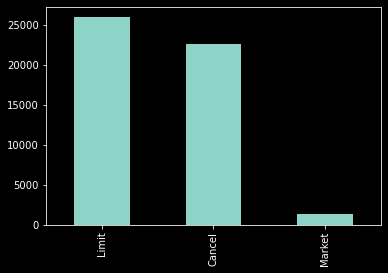

In [18]:
message["Type"].value_counts().plot.bar()